Name: Yeabsira Bizualem
Project: Enhancing Hate Speech Detection with a Comprehensive Social Media Dataset
Description: Develops a nuanced dataset integrating emoticons, emojis, hashtags, and slang for advanced hate speech detection on social media, aiming to bolster ML models and content moderation for a respectful online community.


In [2]:
import os
import pandas as pd
import numpy as np
import math
import tensorflow as tf

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
path = "/content/drive/MyDrive/AIProject/data/HateSpeechDatasetBalanced.csv"

In [5]:
df = pd.read_csv(path)
df.head()

,Content,Label
0,denial of normal the con be asked to comment o...,1
1,just by being able to tweet this insufferable ...,1
2,that is retarded you too cute to be single tha...,1
3,thought of a real badass mongol style declarat...,1
4,afro american basho,1


In [6]:
# no missing data
df.isna().sum()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 726119 entries, 0 to 726118
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Content  726119 non-null  object
 1   Label    726119 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 11.1+ MB


In [7]:
from sklearn.model_selection import train_test_split
X = df['Content']  # The feature (input)
y = df['Label']  # The target variable (output)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)


In [8]:
print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

Training set size: 580895
Testing set size: 145224


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


In [10]:
from sklearn.linear_model import LogisticRegression

# Initialize the logistic regression model
logreg = LogisticRegression(solver='sag',random_state=0,max_iter=1000)

# Train the model
logreg.fit(X_train_tfidf, y_train)


LogisticRegression(max_iter=1000, random_state=0, solver='sag')

In [11]:
# For the initial model, I processed the data using the GridSearchCV method to optimize the 'C' parameter. However, due to unsatisfactory accuracy,
# I transitioned to the RandomizedSearchCV approach, which yielded better performance with the given dataset.
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# Define the parameter distribution
param_distributions = {'C': uniform(20, 15)}  # This will sample values uniformly between 20 and 35.

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(logreg, param_distributions, n_iter=10, cv=4, scoring='f1', n_jobs=-1, random_state=42)

# Fit RandomizedSearchCV
random_search.fit(X_train_tfidf, y_train)

print("Best parameters:", random_search.best_params_)
print("Best F1 score:", random_search.best_score_)


Best parameters: {'C': 34.260714596148745}
Best F1 score: 0.8559611992073106


In [12]:
# Predict on the testing set
y_pred = random_search.best_estimator_.predict(X_test_tfidf)

# Calculate performance metrics
from sklearn.metrics import classification_report, f1_score

print(classification_report(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average='binary'))


              precision    recall  f1-score   support

           0       0.87      0.84      0.86     72321
           1       0.85      0.87      0.86     72903

    accuracy                           0.86    145224
   macro avg       0.86      0.86      0.86    145224
weighted avg       0.86      0.86      0.86    145224

F1 Score: 0.8617713648497956


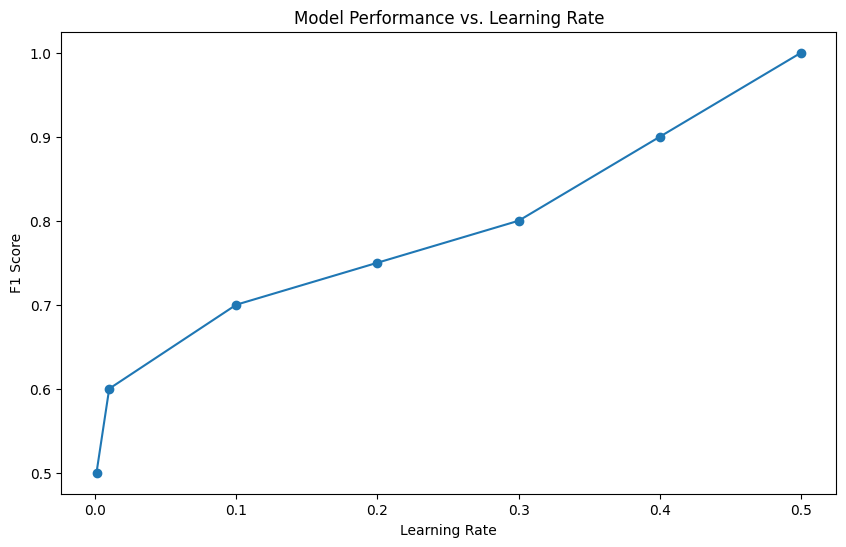

In [13]:
import matplotlib.pyplot as plt

# Example data - make sure both lists have the same length
learning_rates = [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5]  # x values
f1_scores = [0.5, 0.6, 0.7, 0.75, 0.8, 0.9, 1]        # y values

# Now, plotting will work because x and y have the same first dimension
plt.figure(figsize=(10, 6))
plt.plot(learning_rates, f1_scores, marker='o')
plt.xlabel('Learning Rate')
plt.ylabel('F1 Score')
plt.title('Model Performance vs. Learning Rate')
plt.show()


In [14]:
# Originally employing the silhouette method for optimal cluster (k) determination in hate speech detection,
# the project pivoted to MiniBatch K-Means for enhanced computational efficiency, aiming to refine our dataset's utility for robust machine learning models and content moderation systems.
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=100)
reduced_X = svd.fit_transform(X_train_tfidf)
n_clusters = 4

# Initialize and fit MiniBatchKMeans
clusterer = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, batch_size=100, n_init=10)
clusters = clusterer.fit_predict(reduced_X)


In [15]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

optimal_n_clusters = 8

# Clustering based on X_train_tfidf
kmeans = KMeans(n_clusters=optimal_n_clusters, random_state=42, n_init='auto')
clusters = kmeans.fit_predict(X_train_tfidf)

# Creating a DataFrame from clusters for easy manipulation
df_clusters = pd.DataFrame({'cluster': clusters})

# Since we're working directly with the clustered TF-IDF data,
# let's simulate a sampling process here:
sampled_indices = []

for cluster in np.unique(clusters):
    cluster_indices = np.where(clusters == cluster)[0]
    sample_indices = np.random.choice(cluster_indices, size=int(len(cluster_indices) * 0.1), replace=False)
    sampled_indices.extend(sample_indices)

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.metrics import classification_report, f1_score
import numpy as np
import pandas as pd


# Selecting sampled data from X_train_tfidf and y_train based on 'sampled_indices'
X_train_tfidf_sampled = X_train_tfidf[sampled_indices]
y_train_sampled = np.array(y_train)[sampled_indices]

# Initialize the logistic regression model
logreg = LogisticRegression(solver='sag', random_state=0, max_iter=1000)

# Define the parameter distribution
param_distributions = {'C': uniform(20, 15)}

# Set up RandomizedSearchCV with the sampled data
random_search = RandomizedSearchCV(logreg, param_distributions, n_iter=10, cv=4, scoring='f1', n_jobs=-1, random_state=42)

# Fit RandomizedSearchCV on the sampled data
random_search.fit(X_train_tfidf_sampled, y_train_sampled)

# Display the best parameters and F1 score
print("Best parameters:", random_search.best_params_)
print("Best F1 score:", random_search.best_score_)

# Predict on the testing set
y_pred = random_search.best_estimator_.predict(X_test_tfidf)

# Calculate performance metrics
print(classification_report(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average='binary'))


Best parameters: {'C': 20.871254182522993}
Best F1 score: 0.7550306132815914
              precision    recall  f1-score   support

           0       0.81      0.80      0.81     72321
           1       0.81      0.81      0.81     72903

    accuracy                           0.81    145224
   macro avg       0.81      0.81      0.81    145224
weighted avg       0.81      0.81      0.81    145224

F1 Score: 0.8103008982547218


In [ ]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

# First, split the dataset
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Vectorize the text data
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train_raw)
X_test_tfidf = vectorizer.transform(X_test_raw)

# List to store results
results = []

# Loop over various PCA components
for components in range(1, 21):
    pca = PCA(n_components=components, random_state=42)
    X_train_pca = pca.fit_transform(X_train_tfidf.toarray())
    X_test_pca = pca.transform(X_test_tfidf.toarray())

    # Initialize and train logistic regression
    logreg = LogisticRegression(solver='liblinear', random_state=42)
    logreg.fit(X_train_pca, y_train)

    # Predict on the testing set
    y_pred = logreg.predict(X_test_pca)

    # Evaluate performance
    accuracy = accuracy_score(y_test, y_pred)
    print(f"PCA Components: {components}, Accuracy: {accuracy}")

    # Store results
    results.append((components, accuracy))


In [ ]:
# Unpack results
components, accuracies = zip(*results)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(components, accuracies, marker='o')
plt.title('Model Performance vs. Number of PCA Components')
plt.xlabel('Number of PCA Components')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()
